In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/language-detection-data/itlaian.txt
/kaggle/input/language-detection-data/spanish.txt
/kaggle/input/language-detection-data/french.txt
/kaggle/input/language-detection-data/english.txt
/kaggle/input/language-detection-data/german.txt


In [2]:
def load_text_file(file_path, column_name):
    """
    Load a text file with each line as a new row and a single column.

    Parameters:
    file_path (str): The path to the text file.
    column_name (str): The name of the column for the DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with one column containing the text from the file.
    """
    with open(file_path, encoding="utf-8") as file:
        lines = file.readlines()
        
    lines = [line.strip() for line in lines]
    
    df = pd.DataFrame(lines, columns=[column_name])
    
    return df

In [3]:
# Load Datasets

eng_df = load_text_file("/kaggle/input/language-detection-data/english.txt", "English")
spa_df = load_text_file("/kaggle/input/language-detection-data/spanish.txt", "Spanish")
ger_df = load_text_file("/kaggle/input/language-detection-data/german.txt", "German")
ita_df = load_text_file("/kaggle/input/language-detection-data/itlaian.txt", "Italian")
fre_df = load_text_file("/kaggle/input/language-detection-data/french.txt", "French")

In [4]:
print(f"shape of Dataset : {eng_df.shape}")
print(f"shape of Dataset : {spa_df.shape}")
print(f"shape of Dataset : {fre_df.shape}")
print(f"shape of Dataset : {ger_df.shape}")
print(f"shape of Dataset : {ita_df.shape}")

shape of Dataset : (1000, 1)
shape of Dataset : (1000, 1)
shape of Dataset : (1000, 1)
shape of Dataset : (1000, 1)
shape of Dataset : (1000, 1)


In [5]:
# Data Pre-Processing
import string
import re

punctuation_table = dict((ord(char),None) for char in string.punctuation)

def preprocess_data(df, column_name, punctuation_table):
    """
    Preprocesses text data in a DataFrame by lowercasing, removing digits,
    and translating punctuation, then appends to data and language label lists.

    Parameters:
    df (pd.DataFrame): The DataFrame containing text data.
    column_name (str): The name of the column containing text data.
    punctuation_table (dict): Dictionary mapping punctuation characters to None.

    Returns:
    list, list: Two lists containing preprocessed text data and corresponding language labels.
    """
    data_list = []
    lang_list = []

    for i, row in df.iterrows():
        line = row[column_name]
        if line != 0:
            line = line.lower()
            line = re.sub(r"\d+", "", line)
            line = line.translate(punctuation_table)
            data_list.append(line)
            lang_list.append(column_name)

    return data_list, lang_list

In [6]:
eng_data , eng_lang = preprocess_data(eng_df, "English", punctuation_table)
fre_data , fre_lang = preprocess_data(fre_df, "French", punctuation_table)
spa_data , spa_lang = preprocess_data(spa_df, "Spanish", punctuation_table)
ger_data , ger_lang = preprocess_data(ger_df, "German", punctuation_table)
ita_data , ita_lang = preprocess_data(ita_df, "Italian", punctuation_table)

In [7]:
df = pd.DataFrame({"text":eng_data+ger_data+fre_data+spa_data+ita_data,
                   "language":eng_lang+ger_lang+fre_lang+spa_lang+ita_lang})

In [8]:
df.shape

(5000, 2)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import pipeline

In [10]:
X,y = df.iloc[:,0],df.iloc[:,1]
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)

print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

X_train : (4000,)
X_test : (1000,)
y_train : (4000,)
y_test : (1000,)


In [11]:
# Vectorizer and Model Fitting Pipeline

vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1,3),analyzer='char')

pipe = pipeline.Pipeline(
                        [('vectorizer',vectorizer),
                        ('classifier',linear_model.LogisticRegression())
])

In [12]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('classifier', LogisticRegression())])

In [13]:
# Model Prediction

y_pred = pipe.predict(X_test)

In [14]:
# Model Evaluation 

acc = (metrics.accuracy_score(y_test,y_pred)) * 100 

print(acc,"%")

99.0 %


In [15]:
matrix = metrics.confusion_matrix(y_test,y_pred)

print("Confusion Matrix : \n" , matrix)

Confusion Matrix : 
 [[213   3   0   0   0]
 [  2 189   1   0   0]
 [  0   0 190   0   0]
 [  1   2   0 189   0]
 [  1   0   0   0 209]]


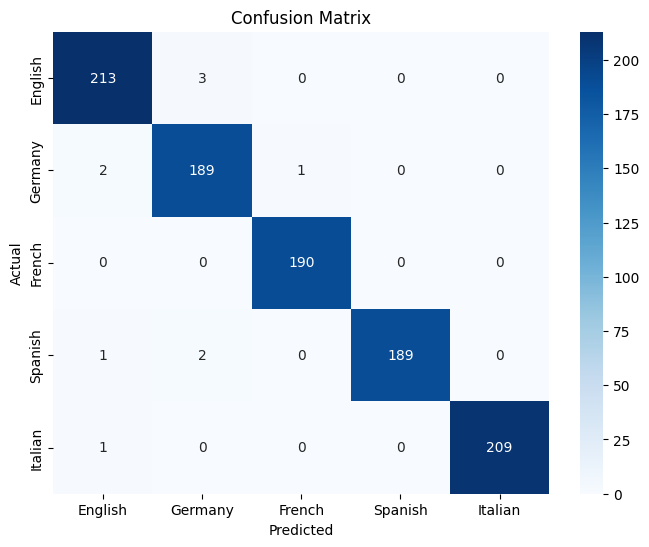

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['English', 'Germany' ,'French' ,'Spanish','Italian'],
            yticklabels=['English', 'Germany' ,'French' ,'Spanish','Italian'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()